<a href="https://colab.research.google.com/github/mmsamiei/final-ms-thesis-code/blob/master/phase3/models/almohandes/almohandes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#In the name of God

In [2]:
import IPython
from google.colab import output

display(IPython.display.Javascript('''
  function ClickConnect(){
    console.log("Working"); 
    document.querySelector("colab-connect-button").click() 
  }
  var connect_timer = setInterval(ClickConnect,60000)
'''))

print("Done.")

<IPython.core.display.Javascript object>

Done.


In [1]:
!nvidia-smi

Tue Sep  8 21:23:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wEYFr6EMv-dakLmZPW6LtMNeRxtuuAfWtapkeab6sZdvI3zHaCfnV8
Mounted at /content/drive


In [4]:
!pip -q install transformers

     |████████████████████████████████| 890kB 4.3MB/s 
     |████████████████████████████████| 1.1MB 13.0MB/s 
     |████████████████████████████████| 890kB 24.4MB/s 
     |████████████████████████████████| 3.0MB 32.8MB/s 


In [5]:
from torch.utils.data import Dataset, DataLoader
import os
import torch
import json
from torch.utils.data.sampler import SubsetRandomSampler
from transformers import AutoTokenizer
import random
import pandas as pd
import logging
import os

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import AutoModel

import numpy as np
import pandas as pd
import random

random_state = 313

# Dataset

In [6]:
train_file = '/content/drive/My Drive/Thesis/phase-3/hkr_train.csv'
valid_file =  '/content/drive/My Drive/Thesis/phase-3/hkr_valid.csv'
test_seen_file = '/content/drive/My Drive/Thesis/phase-3/hkr_test_seen.csv'
test_unseen_file = '/content/drive/My Drive/Thesis/phase-3/hkr_test_unseen.csv'
last_sentence_file = '/content/drive/My Drive/Thesis/phase-3/last_sentence.csv'
squad_file = '/content/drive/My Drive/Thesis/phase-3/squad.csv'
opensubtitle_file = '/content/drive/My Drive/Thesis/phase-3/opensubtitle.csv'
cornell_file = '/content/drive/My Drive/Thesis/phase-3/cornell.csv'

In [7]:
enc_tokenizer = AutoTokenizer.from_pretrained('facebook/bart-base')
dec_tokenizer = AutoTokenizer.from_pretrained('facebook/bart-base')

In [8]:
enc_tokenizer.encode("~")

[0, 34437, 2]

In [9]:
class MyDataset(Dataset):
    """My dataset."""

    def __init__(self, csv_file, split_rate=1, max_len=128, shift=0, sort=True, train=False):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
        """

        self.train = train

        self.dialogues = pd.read_csv(csv_file)
        #self.dialogues.dropna(inplace=True)
        
        self.dialogues.fillna("", inplace=True)
        self.dialogues = self.dialogues[self.dialogues.index % split_rate == 0]

        self.dialogues.history = self.dialogues.history.str.replace(
            "[SEP]", "</s>", n=-1, regex=False) ### SPECIAL CHARACHTER FOR TURN
        

        #self.dialogues = self.dialogues.sample(frac=1, random_state=random_state).reset_index(drop=True)

        s = self.dialogues['history'].apply(len).sort_values().index
        self.dialogues = self.dialogues.reindex(s)

        s = self.dialogues['knowledge'].apply(len).sort_values().index
        self.dialogues = self.dialogues.reindex(s)

        s = self.dialogues['response'].apply(len).sort_values().index
        self.dialogues = self.dialogues.reindex(s)

        self.dialogues = self.dialogues.reindex(index=np.roll(self.dialogues.index,shift))

        self.max_len = max_len


    def __len__(self):
        return len(self.dialogues)

    @staticmethod
    def truncuate_join_pair_sentence(sentence1, sentence2, max_len=510):

        """
        truncuate sentence one from head and sentence two from tail
        Args:
            sentence1 (string): first sentence
            sentence2 (string): seconde sentence
        """
        temp1 = enc_tokenizer.encode(sentence1,add_special_tokens=False)
        temp2 = enc_tokenizer.encode(sentence2,add_special_tokens=False)
        ### two above line may cause warning but no problem because we've handle them below
        logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)
        seq_1 = temp1
        seq_2 = temp2
        num_tokens_to_remove = len(temp1) + len(temp2) + 3 - max_len
        if num_tokens_to_remove > 0 :
            seq_1, seq_2, _ = enc_tokenizer.truncate_sequences(temp1[::-1],temp2, num_tokens_to_remove=num_tokens_to_remove,
                                                               truncation_strategy='longest_first')
            seq_1.reverse()
        result_list = [enc_tokenizer.cls_token_id]+seq_1+[enc_tokenizer.sep_token_id]+[12905]+seq_2+[34437]
        token_type_ids = [0] * (len(seq_1) + 2) + [1] * (len(seq_2) + 2)
        if(len(result_list)>1000):
          print(len(result_list))

        return result_list, token_type_ids


    def __getitem__(self, idx):
      
        
        history = self.dialogues.iloc[idx].history
        knowledge = self.dialogues.iloc[idx].knowledge
        response = self.dialogues.iloc[idx].response

        # if self.train:
        #   r = random.choice(range(len(train_dataset.dialogues)))
        #   noise_knowledge = self.dialogues.iloc[r].knowledge
        #   if random.random() > 0.5:
        #     knowledge = knowledge  + noise_knowledge
        #   else:
        #     knowledge = noise_knowledge +  knowledge

        input_pair, input_pair_segments = MyDataset.truncuate_join_pair_sentence(history, knowledge, self.max_len)
                

        input_pair = torch.LongTensor(input_pair)

        input_pair_segments = torch.LongTensor(input_pair_segments)

        response_tensor = torch.LongTensor(dec_tokenizer.encode(response, truncation=True, max_length=128))

        sample = {'input_pair': input_pair,
                  'input_pair_segments': input_pair_segments,
                  'response': response_tensor}

        return sample


In [10]:
train_dataset = MyDataset(train_file, max_len=128, train=True)
valid_dataset = MyDataset(valid_file, split_rate=2, max_len=128)
test_unseen_dataset = MyDataset(test_unseen_file, max_len=128)
test_seen_dataset = MyDataset(test_seen_file, max_len=128)
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_unseen_dataset))
print(len(test_seen_dataset))

41489
2229
2075
2224


In [14]:
enc_tokenizer.encode("<mask>")

[0, 50264, 2]

In [15]:
print(enc_tokenizer.decode(train_dataset[2]['input_pair']))
print(dec_tokenizer.decode(train_dataset[2]['response']))

<s> and Canadian football </s> Really? I like American football </s> they are the best players </s> What is the other name for American football? </s> american football is known as gridiron football or simply gridiron </s> Why is it called American football? </s>  is a team sport played by two teams of eleven players on a rectangular field with goalposts at each end </s> OK. When was the first game played in the United States?</s>`The Blue Jays clinched a playoff berth on September 25, their first since 1993, ending what was the longest playoff drought in North American professional sports at the time.~
<s>1993</s>


In [37]:
a = torch.rand((4,6))
b = torch.rand_like(a)
a[b<0.3] = 3
a

tensor([[0.7988, 0.8550, 0.8100, 0.6059, 0.8911, 0.1516],
        [0.4583, 0.7746, 3.0000, 0.1547, 0.8549, 0.2214],
        [3.0000, 3.0000, 0.2335, 0.5985, 0.5398, 3.0000],
        [0.5456, 0.7204, 0.8016, 0.6740, 0.6273, 0.2907]])

In [45]:
from tqdm.auto import tqdm

def my_collate_fn(batch):

  len_batch = len(batch)

  
  max_len_input_pair = max([len(data['input_pair']) for data in batch])

  max_len_response = max([len(data['response']) for data in batch])
  
  padding_ind = 1 ## for bart is 0 DON'T THINK BAD IT IS NOT REFACTORING !!!!!!
  result_input_pair = torch.ones(len_batch, max_len_input_pair)
  result_input_pair_segments = torch.zeros(len_batch, max_len_input_pair)
  result_response = torch.ones(len_batch, max_len_response)

  for i, data in enumerate(batch):
    p1 = len(data['input_pair'])
    result_input_pair[i, :p1] = data['input_pair']

    p3 = len(data['input_pair_segments'])
    result_input_pair_segments[i, :p3] = data['input_pair_segments']

    p4 = len(data['response'])
    result_response[i, :p4] = data['response']
  
  mask = torch.rand_like(result_input_pair)
  result_input_pair[mask > 0.85] =  50264

  return result_input_pair.long(), result_input_pair_segments.long(), result_response.long()

# train_sampler = torch.utils.data.SequentialSampler(train_dataset)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16,
                                           collate_fn=my_collate_fn,
                                           shuffle=True,
                                           num_workers=0)

#valid_sampler = torch.utils.data.SequentialSampler(valid_dataset)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16,
                                             shuffle=False, collate_fn=my_collate_fn, num_workers=1)

i = 0 
for batch_idx, batch  in tqdm(enumerate(train_loader)):
  pair_batch, segment_batch, response_batch = batch
  print(pair_batch.shape)
  print(segment_batch.shape)
  print(response_batch.shape)
  print("****")
  i += 1 
  if(i==2):
    break

print(len(train_loader))
print(len(valid_loader))

torch.Size([16, 129])
torch.Size([16, 129])
torch.Size([16, 47])
****
torch.Size([16, 129])
torch.Size([16, 129])
torch.Size([16, 49])
****
2594
140


In [46]:
dec_tokenizer.batch_decode(pair_batch)

['<s><mask>kshake </s> milkshakes are awesome beverages<mask><mask> sweet </s> I love them so much, especially Oreo ones<mask> </s> Ye<mask> its great when they flavor it with milk and ice cream <mask> That would make sense, since<mask> are called milkshakes<mask>.</s>`A milkshake is<mask> sweet, cold beverage<mask> is usually made<mask> milk, ice cream, or iced<mask><mask> and flavorings or<mask>eners such as but<mask>cotch, caramel sauce, chocolate syrup,<mask><mask> syrup.~<pad><pad><pad><pad><pad><pad><pad><pad><mask><pad><pad><pad><pad><mask><pad><pad><pad><pad><pad>',
 '<mask>Mileena </s> my favorite mortal<mask> character is milena. I love his occasional boss character in the  series of fighting games </s>  think<mask> favortie is Sub Zero in thath game<mask><mask> Oh yeah he is interesting too as a  formidable fighter possessing<mask> innate ability to control ice in many forms </s> Yeah as a kid I kinda thought he was the coolest pun intended.</s>`Sub<mask>Zero<mask> the alias

# Model

In [47]:
from transformers import EncoderDecoderModel, BertTokenizer
from transformers import BartForConditionalGeneration

class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()

    # self.seq2seq = EncoderDecoderModel.from_encoder_decoder_pretrained(
    #     'google/bert_uncased_L-2_H-128_A-2', 'google/bert_uncased_L-6_H-128_A-2')
    
    # for p in self.seq2seq.encoder.embeddings.parameters():
    #    p.requires_grad = False
    
    # for p in self.seq2seq.decoder.bert.embeddings.parameters():
    #    p.requires_grad = False

    self.seq2seq = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

  def forward(self, encoder_input, segments_tensors, decoder_input, **kwargs):
    '''
    encoder_input = [batch_size, enc_len]
    segments_tensors = [batch_size, enc_len]
    decoder_input = [batch_size, dec_len]
    '''
    #kwargs = {'token_type_ids':segments_tensors}
    #kwargs = {}
    outputs = self.seq2seq(input_ids=encoder_input,
                           decoder_input_ids=decoder_input,
                           use_cache=False, **kwargs)[0]
    return outputs
  
  def generate(self, encoder_input, segments_tensors, **kwargs):
    ### encoder_input = [len] in int format
    ### segment_tensors = [len]
    encoder_input = encoder_input.unsqueeze(0)
    segments_tensors = segments_tensors.unsqueeze(0)
    
    model_specific_kwargs = {}
    #model_specific_kwargs['token_type_ids'] = {'token_type_ids':segments_tensors}

    generated = model.seq2seq.generate(encoder_input, decoder_start_token_id=0,
                                       eos_token_id=2, ## <s> = 0 </s> = 2
                                       **kwargs, **model_specific_kwargs)

    #### generated = [1, len]
    return generated

In [48]:
dev = torch.device('cuda')
model = Model().to(dev)

# x = torch.LongTensor(8, 40).random_(1,1000).to(dev)
# y = torch.LongTensor(8, 10).random_(1,1000).to(dev)
# print(model(x,x,y).shape)


def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))


139420416


#Optimizer



In [49]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
decoder_optimizer = torch.optim.Adam(model.seq2seq.model.decoder.parameters(), lr=1e-5)

In [50]:
from transformers import get_cosine_schedule_with_warmup, get_constant_schedule
scheduler = get_constant_schedule(optimizer)
decoder_scheduler = get_constant_schedule(decoder_optimizer)

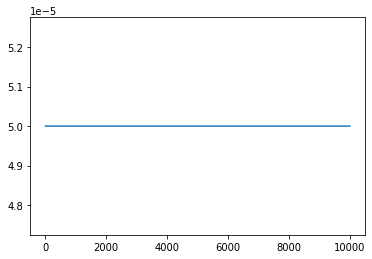

In [ ]:
lrs = []
for i in tqdm(range(10000)):
  optimizer.step()
  scheduler.step()
  lrs.append(scheduler.get_last_lr()[0])
import matplotlib.pyplot as plt
plt.plot(lrs)

# Training

In [ ]:
df = pd.read_csv(train_file)
freqs = [1] * dec_tokenizer.vocab_size
for response in tqdm(df['response']):
  tknzd = dec_tokenizer.encode(response)
  for tkn in tknzd:
    freqs[tkn] += 1

Token indices sequence length is longer than the specified maximum sequence length for this model (1037 > 1024). Running this sequence through the model will result in indexing errors


In [51]:
def get_weights(_lambda = 0):
  weights = torch.ones(dec_tokenizer.vocab_size)
  # for idx, freq in enumerate(freqs):
  #   weight = 1 / (freq**_lambda)
  #   weights[idx] = weight
  return weights

In [52]:
import torch.nn

weight = get_weights().to(dev)

def mahdi_loss(model_output, true_trg, **kwargs):
  '''
  model_output: [batch, len, hidden]
  true_trg: [batch, len]
  '''
  model_output = model_output[:,:-1,:]
  true_trg = true_trg[:,1:]

  batch_len = model_output.shape[0]
  snt_len = model_output.shape[1]
  hidden_size = model_output.shape[2]

  model_output = model_output.reshape(-1, hidden_size)
  true_trg = true_trg.reshape(-1)

  loss_mod = nn.CrossEntropyLoss(weight=weight, ignore_index=1)## PAD = 1
  loss = loss_mod(model_output, true_trg)



  #z = torch.LongTensor(model_output[true_trg!=1045].shape[0]).fill_(1045).to(dev)
  #neg_loss = -0.5*F.nll_loss(nn.functional.log_softmax(model_output[true_trg!=1045]), z, reduction='mean')

  return loss 

In [54]:
from tqdm.auto import tqdm

accumulation_steps = 4

def train_step(batch_idx, batch, step):
  pair_batch, segment_batch, response_batch = batch
  pair_batch = pair_batch.to(dev)
  segment_batch = segment_batch.to(dev)
  response_batch = response_batch.to(dev)
  model_output = model(pair_batch, segment_batch, response_batch)
  loss = mahdi_loss(model_output, response_batch)
  loss = loss / accumulation_steps
  loss.backward()
  torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
  if (step+1) % accumulation_steps == 0:
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  del pair_batch
  del segment_batch
  del response_batch
  return loss.item()


### UNDER CONSTRUCT
def train_decoder_step(batch_idx, batch):
  pair_batch, segment_batch, response_batch = batch
  batch_size = pair_batch.shape[0]
  response_batch = response_batch.to(dev)
  encoder_outputs = torch.Tensor(batch_size,20,768).fill_(0).to(dev)
  kwargs = {'encoder_outputs' : (encoder_outputs, None, None)}
  model_output = model(None, None, response_batch, **kwargs)
  loss = mahdi_loss(model_output, response_batch)
  decoder_optimizer.zero_grad()
  loss.backward()
  torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
  decoder_optimizer.step()
  decoder_scheduler.step()
  del pair_batch
  del segment_batch
  del response_batch
  return loss.item()

def valid_step(batch_idx, batch):
  with torch.no_grad():
    pair_batch, segment_batch, response_batch = batch
    pair_batch = pair_batch.to(dev)
    segment_batch = segment_batch.to(dev)
    response_batch = response_batch.to(dev)
    model_output = model(pair_batch, segment_batch, response_batch)
    loss = mahdi_loss(model_output, response_batch)
    del pair_batch
    del segment_batch
    del response_batch
    return loss.item()

def valid_loop(valid_loader):
  total_loss = 0
  model.eval()
  for batch_idx, batch in enumerate(valid_loader):
    total_loss += valid_step(batch_idx, batch)
  
  print("temperature is 1:")
  kwargs = {'num_beams':4,'num_return_sequences':4,'temperature':1,
            'no_repeat_ngram_size':3}
  valid_inference(**kwargs)

  print("most greedy sentence:")
  kwargs = {
          'num_return_sequences':1,'temperature':1, 'max_length':50, 'early_stopping':True,
          'no_repeat_ngram_size':3,
          #'top-k':1
          }
  valid_inference(**kwargs)

  # print("temperature is 2:")
  # kwargs = {'num_beams':16,'num_return_sequences':16,'temperature':2}
  # valid_inference(**kwargs)


  model.train()
  return total_loss / len(valid_loader)

def valid_inference(idx=600, **kwargs):
  hk_pair =  valid_dataset[idx]['input_pair'].to(dev)
  hk_segment = valid_dataset[idx]['input_pair_segments'].to(dev)
  response = valid_dataset[idx]['response'].to(dev)
  generateds = model.generate(hk_pair, hk_segment, **kwargs)
  print("pair is: ",enc_tokenizer.decode(hk_pair))
  print("response is: ",dec_tokenizer.decode(response))
  for generated in generateds:
    print("model says: ",dec_tokenizer.decode(generated))

In [55]:
MODEL_NAME = "almohandes"
new_learning = True
if new_learning:
  # optimizer = NoamOpt(128, 1, 2000,
  #           torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
  model_dir = "/content/drive/My Drive/Final-Thesis/Phase3/Al-Mohandes/"
  step = 0
  best_val = 1000
  log_list = []

In [57]:
## if continue learning:
#!wget -q https://github.com/mmsamiei/MS-Thesis-Phase2/raw/master/Models/hashemi_16000steps.model
model_dir = "/content/drive/My Drive/Final-Thesis/Phase3/Bahonar/"
checkpoint = torch.load(model_dir+'hemmat.model')
step = checkpoint['log_list'][-1]['step']
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
optimizer._step = step
best_val = checkpoint['best_val']
log_list = checkpoint['log_list']
new_learning = False
print(step)

709000


In [ ]:
model_dir = "/content/drive/My Drive/Final-Thesis/Phase3/Zeinoddin/"
step = 0

In [ ]:
from tqdm.auto import tqdm

MAX_STEP = 25000
STEP_SAVE = 1000
STEP_CHECK = 2500
step_num = step + 1
log_list = log_list ### Check if new learning or not
print(step_num)
while step_num <= MAX_STEP:
  model.train()
  for batch_idx, batch in enumerate(iter(train_loader)):
    step_loss = train_step(batch_idx, batch, step_num)
    #decoder_step_loss = train_decoder_step(batch_idx, batch)
    #log = {'step':step_num, 'train_loss':step_loss, 'decoder_loss':decoder_step_loss}
    log = {'step':step_num, 'train_loss':step_loss, 'hemmat':True}

    if(step_num % STEP_CHECK == 0):
      valid_error = valid_loop(valid_loader)
      train_losses = [step['train_loss'] for step in log_list[-100:]]
      #decoder_train_losses = [step['decoder_loss'] for step in log_list[-100:]]
      avg_train_loss = sum(train_losses) / len(train_losses)
      #avg_decoder_train_loss = sum(decoder_train_losses) / len(decoder_train_losses)
      print("train Loss rate: {} at step {}".format(avg_train_loss, step_num))  
      #print("decoder train Loss rate: {} at step {}".format(avg_decoder_train_loss, step_num))
      print("valid Loss rate: {} at step {}".format(valid_error, step_num))  
      log['valid_loss'] = valid_error

      if valid_error < best_val:
        best_val = valid_error
        torch.save({
            'model_state_dict': model.state_dict(),
            'log_list': log_list,
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val' : best_val
            }, model_dir+'bahonar0k_zeinoddin_bestval.model')

    log_list.append(log)

    if(step_num % STEP_SAVE == 0):
      torch.save({
            'model_state_dict': model.state_dict(),
            'log_list': log_list,
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val': best_val
            }, model_dir+'bahonar0k_zeinoddin.model')
    step_num += 1

    # if(step_num % 5000 == 0):
    #   torch.save({
    #         'model_state_dict': model.state_dict(),
    #         'log_list': log_list,
    #         'optimizer_state_dict': optimizer.state_dict()
    #         }, model_dir+'bahonar0k_hemmat{}.model'.format(step_num))

1


In [ ]:
model.eval()
kwargs = {'num_beams':1,
          'num_return_sequences':1,'temperature':1, 'max_length':300, 'early_stopping':True,
          'no_repeat_ngram_size':2,
          #'min_length':100,
          #'do_sample':True,
          #'top-k':1
          }
valid_inference(idx=3000, **kwargs)

IndexError: ignored

In [ ]:
text = '''
<s> how can i apply to stanford university? </s>
` You can apply to Stanford by submitting online either the Coalition Application or the Common Application . Both applications include essay prompts for your personal essay ~ 
'''


input_tns = dec_tokenizer.encode(text, return_tensors='pt').squeeze(0).to(dev)


kwargs = {'num_beams':1,
          'num_return_sequences':1,'temperature':1, 'max_length':50, 'early_stopping':True,
          'no_repeat_ngram_size':3,
          #'do_sample':True, 'top_p':0.95
          }
dec_tokenizer.batch_decode(model.generate(input_tns, input_tns, **kwargs))

['<s>You can apply by using the online application.</s>']

In [ ]:
import numpy as np
logging.getLogger("transformers").setLevel(logging.ERROR)

model.eval()
f_scores = []
for i in tqdm(range(len(test_unseen_dataset))):
  kwargs = {'num_beams':1,
            'num_return_sequences':1,'temperature':1, 'max_length':300, 'early_stopping':True,
            'no_repeat_ngram_size':2,
            #'top-k':1
            }
  idx = 100
  hk_pair =  test_unseen_dataset[i]['input_pair'].to(dev)
  hk_segment = test_unseen_dataset[i]['input_pair_segments'].to(dev)
  response = test_unseen_dataset[i]['response'].to(dev)
  generateds = model.generate(hk_pair, hk_segment, **kwargs)
  generateds = generateds.squeeze(0).cpu().numpy()
  response = response.squeeze(0).cpu().numpy()
  intersections = np.intersect1d(generateds, response)
  recall = len(intersections) / len(response)
  precision = len(intersections) / len(generateds)
  f1_score = 2 * (precision * recall) / (precision + recall)
  f_scores.append(f1_score)
  if i % 100 == 0:
    print(sum(f_scores) / len(f_scores))

print( sum(f_scores) / len(f_scores))

0.22222222222222224
0.35659091496644607
0.38057490398713406
0.3827522581852573
0.38431841936141403
0.38855632630693937
0.3871028568293454
0.387005112316739
0.3900072545270044
0.38931205122135376
0.38769186846110715
0.3888491688283531
0.39114089863688356
0.3897845314533675
0.3903651676731629
0.39077191879042666
0.390358314356112
0.38843369292277174
0.38670599113539267
0.38482970813654677
0.3840457532989933

0.38242231371570723


In [ ]:
import numpy as np
logging.getLogger("transformers").setLevel(logging.ERROR)
from nltk.translate.bleu_score import sentence_bleu

model.eval()
bleus = []
for i in tqdm(range(len(test_unseen_dataset))):
  kwargs = {'num_beams':10,
            'num_return_sequences':1,'temperature':1, 'max_length':50, 'early_stopping':True,
            'no_repeat_ngram_size':1,
            #'top-k':1
            }
  idx = 100
  hk_pair =  test_unseen_dataset[i]['input_pair'].to(dev)
  hk_segment = test_unseen_dataset[i]['input_pair_segments'].to(dev)
  response = test_unseen_dataset[i]['response'].to(dev)
  generateds = model.generate(hk_pair, hk_segment, **kwargs)
  generateds = generateds.squeeze(0).cpu().numpy()
  response = response.squeeze(0).cpu().numpy()
  bleu = sentence_bleu([response], generateds,weights=(0.25, 0.25, 0.25, 0.25))
  bleus.append(bleu)
  if i%100 == 0:
    print( sum(bleus) / len(bleus))

print( sum(bleus) / len(bleus))

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.5623413251903491
0.5298123286439488
0.47594969954812333
0.43807145548061666
0.40842677057790155
0.38469455216463655
0.3638016732935127
0.3448276615670687
0.3283755259226166
0.31320767765169766
0.29923337023230623
0.28636405556534106
0.2742542879460828
0.26304637998976205
0.25226153321908057
0.24199565088854522


KeyboardInterrupt: ignored